In [52]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

In [29]:
imdb = tf.keras.datasets.imdb
(train_data, train_labels), (test_data, test_label) = imdb.load_data(num_words = 10000)

In [30]:
print("training data: {}, labels: {}".format(len(train_data), len(train_labels)))

training data: 25000, labels: 25000


In [31]:
print(train_data.shape,test_data.shape)

(25000,) (25000,)


In [32]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Movie reviews may be different lengths. The below code shows the number of words in the first and second reviews. **Since inputs to a neural network must be the same length, we'll need to resolve this later.**

In [33]:
len(train_data[0]) ,len(train_data[1])

(218, 189)

In [34]:
# a directory mapping words to integer index
word_index = imdb.get_word_index()

word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [35]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [36]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [37]:
len(train_data[0]) ,len(train_data[1])

(256, 256)

In [38]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

The neural network is created by stacking layers—this requires two main architectural decisions:

* How many layers to use in the model?
* How many hidden units to use for each layer?

In [39]:
test_data.shape

(25000, 256)

In [41]:
vocab_size = 10000
# Other way to create a model
#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, 16))
# ...
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation= tf.nn.sigmoid)
])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
              metrics=['acc'])

In [47]:
x_validation = train_data[:10000]
partial_x_train = train_data[10000:]

y_validation = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [49]:
partial_x_train.shape

(15000, 256)

In [48]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 40,
                   batch_size = 512,
                   validation_data = (x_validation, y_validation),
                   verbose = 1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 80us/sample - loss: 0.6918 - acc: 0.6452 - val_loss: 0.6897 - val_acc: 0.7099
Epoch 2/40
15000/15000 [==============================] - 1s 41us/sample - loss: 0.6863 - acc: 0.7289 - val_loss: 0.6826 - val_acc: 0.7384
Epoch 3/40
15000/15000 [==============================] - 1s 42us/sample - loss: 0.6748 - acc: 0.7551 - val_loss: 0.6676 - val_acc: 0.7466
Epoch 4/40
15000/15000 [==============================] - 1s 42us/sample - loss: 0.6540 - acc: 0.7660 - val_loss: 0.6434 - val_acc: 0.7461
Epoch 5/40
15000/15000 [==============================] - 1s 50us/sample - loss: 0.6210 - acc: 0.7891 - val_loss: 0.6074 - val_acc: 0.7820
Epoch 6/40
15000/15000 [==============================] - 1s 43us/sample - loss: 0.5778 - acc: 0.8121 - val_loss: 0.5656 - val_acc: 0.8037
Epoch 7/40
15000/15000 [==============================] - 1s 48us/sa

In [50]:
results = model.evaluate(test_data,test_label)

25000/25000 [==============================] - 1s 39us/sample - loss: 0.3434 - acc: 0.8700


In [51]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

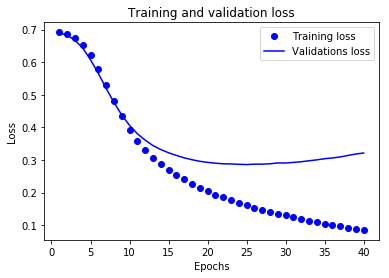

In [53]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs, loss,'bo' ,label = 'Training loss')
plt.plot(epochs, val_loss,'b', label = 'Validations loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

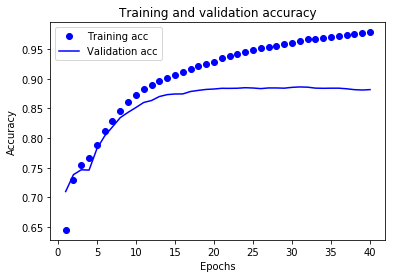

In [54]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

This is an example of **overfitting**: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.